In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from models.convolutional_vae_v2 import ConvolutionalVAEV2 
from models.convolutional_vae_v2 import preprocess_grid as preprocess_vaev2, postprocess_grid as postprocess_vaev2
from models.convolutional_vae_v3 import ConvolutionalVAEV3
from models.convolutional_vae_v3 import preprocess_grid as preprocess_vaev3, postprocess_grid as postprocess_vaev3
from models.convolutional_vqvae import ConvolutionalVQVAE
from models.convolutional_vqvae import preprocess_grid as preprocess_vq, postprocess_grid as postprocess_vq

from models.fully_connected_vae import FullyConnectedVAE
from models.ppca_pipeline import preprocess_grid as preprocess_ppca_into_vae, postprocess_grid as postprocess_ppca_into_vae
from models.ppca_pipeline import get_compression_functions as get_ppca_into_vae_compresison_functions
from models.vq_pipeline import preprocess_grid as preprocess_vq_into_vae, postprocess_grid as postprocess_vq_into_vae
from models.vq_pipeline import get_compression_functions as get_vq_into_vae_compression_functions

from scipy.special import softmax
from scipy.spatial.distance import canberra, mahalanobis
from sklearn.metrics.pairwise import cosine_similarity

from models.pipeline import Pipeline
from utils.view import draw_grid, draw_task
import warnings
warnings.filterwarnings("ignore")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
latent_dim = 512
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=latent_dim,
    feature_dim=[8, 8]
).to(device)

checkpoint = torch.load(f'../../checkpoints/conv_vaev2_{latent_dim}_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev2,
    postprocess_fn=postprocess_vaev2,
)
model_type = "vae"

In [11]:
model = ConvolutionalVAEV3(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=256,
    feature_dim=[4, 4]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev3_256_64_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev3,
    postprocess_fn=postprocess_vaev3,
)
model_type = "vae"

In [48]:
embedding_dim = 256
num_embeddings = 512
model = ConvolutionalVQVAE(
    in_channels=10, 
    starting_filters=64, 
    num_embeddings=num_embeddings,
    embedding_dim=embedding_dim,
    commitment_cost=0.25
).to(device)

checkpoint = torch.load(f'../../checkpoints/conv_vqvae_l{embedding_dim}_c{num_embeddings}.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq,
    postprocess_fn=postprocess_vq,
)
model_type = "vq"

In [4]:
input_dim = 6*6*64
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

checkpoint = torch.load('../../checkpoints/vq_vae_64_b1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_vq_into_vae_compression_functions('../../checkpoints/conv_vqvae_6x6x64_b2.pt')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq_into_vae,
    postprocess_fn=postprocess_vq_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [60]:
n_components = 1024

# input_dim = n_components
input_dim = 128
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

checkpoint = torch.load('../../checkpoints/ppca128_vae_64_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_ppca_into_vae_compresison_functions(f'../../checkpoints/ppca_{n_components}.pkl')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_ppca_into_vae,
    postprocess_fn=postprocess_ppca_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [ ]:
def grid_to_latent(pipeline: Pipeline, grid, model_type="vq"):
    grid = pipeline.preprocess_and_compress(grid)
    z = grid
    # if model_type == 'vq':
    #     z = pipeline.encode(grid.unsqueeze(0).to(device))
    # else:
    #     z, _ = pipeline.encode(grid.unsqueeze(0).to(device))
    
    z_size = z.size()
    z_flat = z.view(z.size(0), -1)

    return z_flat, z_size
    # return grid, grid.size()

def latent_to_grid(pipeline: Pipeline, z, expected_output, model_type="vq"):
    decoded = z
    # if model_type == 'vq':
    #     z_quantized, _, _ = pipeline.model.quantize(z.to(device))
    #     decoded = pipeline.decode(z_quantized)
    # else:
    #     decoded = pipeline.decode(z.unsqueeze(0).to(device))
        
    return pipeline.decompress_and_postprocess(decoded.squeeze(0), expected_output)
    # return pipeline.decompress_and_postprocess(z.squeeze(0), expected_output)

def process_train_pairs(pipeline: Pipeline, train_pairs, model_type="vq"):
    z_inputs = []
    z_diffs = []
    z_size = None
    for input, output in train_pairs:
        z_input, z_size = grid_to_latent(pipeline, input, model_type)
        z_output, _ = grid_to_latent(pipeline, output, model_type)
        z_inputs.append(z_input)
        z_diffs.append(z_output - z_input)
    
    return z_inputs, z_diffs, z_size

def extract_diff(z_diffs, z_inputs, z_test_input, comp="average"):
    if comp == 'average':
        return np.mean(z_diffs, axis=0)
    elif comp == 'scaled_euc':
        support_dists = [np.linalg.norm(support_z - z_test_input) for support_z in z_inputs]
        euc_weights = softmax(-np.array(support_dists))
        return np.sum([w * z for w, z in zip(euc_weights, z_diffs)], axis=0)
    elif comp == 'scaled_cos':
        z_inputs = np.array(z_inputs)
        if z_inputs.ndim > 2:
        # Flatten all dimensions after the first one
            z_inputs_2d = z_inputs.reshape(z_inputs.shape[0], -1)
        else:
            z_inputs_2d = z_inputs
            
        if z_test_input.ndim > 1:
            z_test_input_2d = z_test_input.reshape(1, -1)
        else:
            z_test_input_2d = z_test_input.reshape(1, -1)
        

        cos_sims = cosine_similarity(z_inputs_2d, z_test_input_2d).flatten()
        cos_weights = softmax(cos_sims)
        return np.sum([w * z for w, z in zip(cos_weights, z_diffs)], axis=0)
    elif comp == 'scaled_canberra':
        z_inputs = np.array(z_inputs)
        z_test_input = np.array(z_test_input)

        # Flatten if necessary
        z_inputs_2d = z_inputs.reshape(z_inputs.shape[0], -1) if z_inputs.ndim > 2 else z_inputs
        z_test_input_1d = z_test_input.flatten()

        canberra_dists = [canberra(support_z, z_test_input_1d) for support_z in z_inputs_2d]
        canberra_weights = softmax(-np.array(canberra_dists))
        return np.sum([w * z for w, z in zip(canberra_weights, z_diffs)], axis=0)
    
    elif comp == 'scaled_mahalanobis':
        z_inputs = np.array(z_inputs)
        z_test_input = np.array(z_test_input)
        z_inputs_2d = z_inputs.reshape(z_inputs.shape[0], -1) if z_inputs.ndim > 2 else z_inputs
        z_test_input_1d = z_test_input.flatten()

        # Estimate covariance matrix and its inverse
        cov = np.cov(z_inputs_2d, rowvar=False)
        try:
            inv_cov = np.linalg.inv(cov)
        except np.linalg.LinAlgError:
            # Use pseudo-inverse if matrix is singular
            inv_cov = np.linalg.pinv(cov)

        mahal_dists = [mahalanobis(support_z, z_test_input_1d, inv_cov) for support_z in z_inputs_2d]
        mahal_weights = softmax(-np.array(mahal_dists))
        return np.sum([w * z for w, z in zip(mahal_weights, z_diffs)], axis=0)

    elif comp == 'most_similar':
        support_dists = [np.linalg.norm(support_z - z_test_input) for support_z in z_inputs]
        
        min_idx = np.argmin(support_dists)
        
        return z_diffs[min_idx]


    else:
        return np.zeros_like(z_test_input)

def visual_analogy_single_task(pipeline: Pipeline, train_pairs, test_pair, model_type="vq", comp='average'):
    pipeline.model_eval()

    with torch.no_grad():
        test_input, test_output = test_pair
        z_inputs, z_diffs, z_size = process_train_pairs(pipeline, train_pairs, model_type)
        z_test_input, _ = grid_to_latent(pipeline, test_input, model_type)

        z_diff = extract_diff(z_diffs, z_inputs, z_test_input, comp)
        
        z_pred = z_test_input + z_diff
        z_pred_reshaped = z_pred.view(*z_size)
        
        predicted_output = latent_to_grid(pipeline, z_pred_reshaped, test_output, model_type)
    return predicted_output, test_output

def reconstruct(pipeline: Pipeline, grid, model_type="vq"):
    pipeline.model_eval()
    with torch.no_grad():
        z, _ = grid_to_latent(pipeline, grid, model_type)
        reconstructed_grid = latent_to_grid(pipeline, z, grid, model_type)
    return reconstructed_grid


In [52]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

average


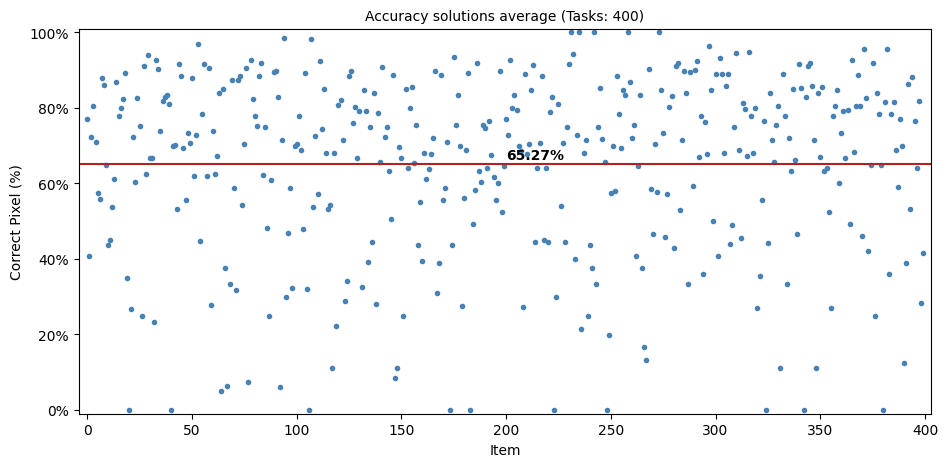

Number of 100% Correct: 5
Number of 90%+ Correct: 42
Number of 80%+ Correct: 130
Number of 70%+ Correct: 208
scaled_euc


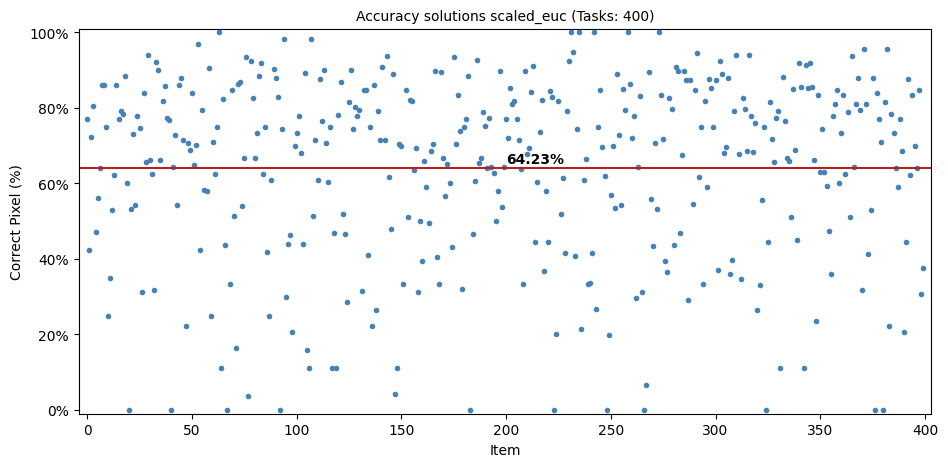

Number of 100% Correct: 6
Number of 90%+ Correct: 37
Number of 80%+ Correct: 121
Number of 70%+ Correct: 205
scaled_cos


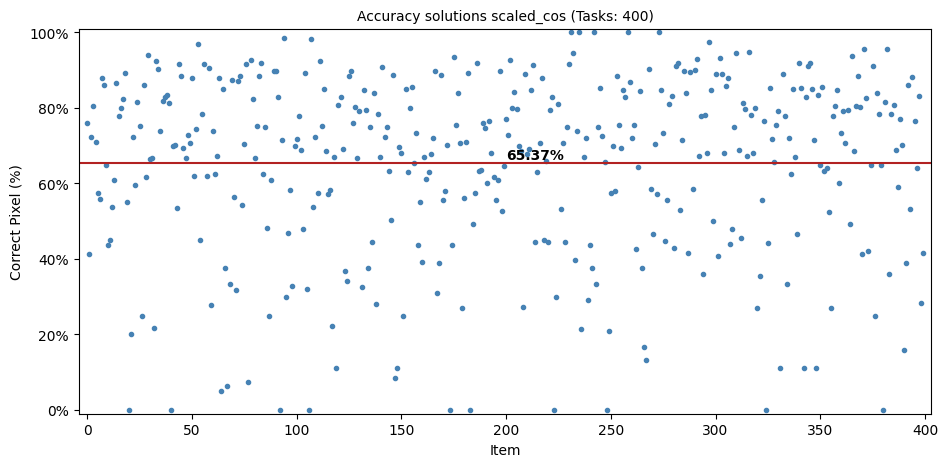

Number of 100% Correct: 5
Number of 90%+ Correct: 41
Number of 80%+ Correct: 129
Number of 70%+ Correct: 209
most_similar


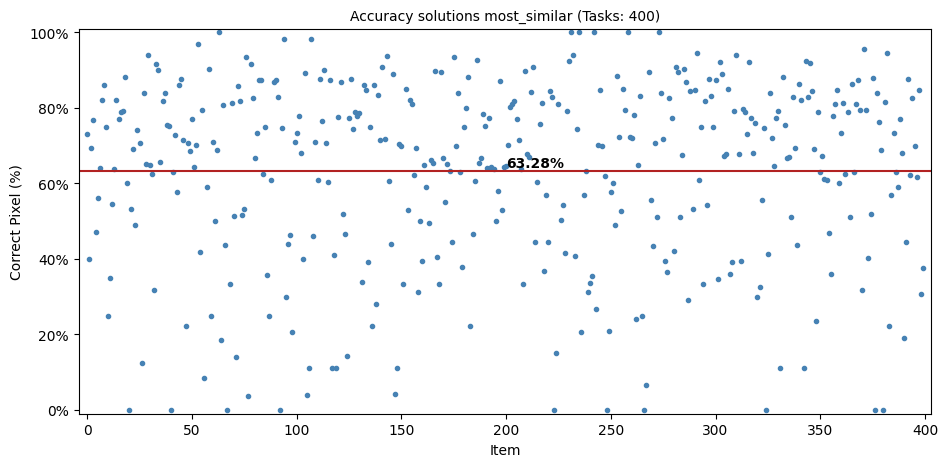

Number of 100% Correct: 6
Number of 90%+ Correct: 33
Number of 80%+ Correct: 116
Number of 70%+ Correct: 195


In [61]:
import pandas as pd
solved_puzzles = []

comps = [
    'average', 
    'scaled_euc', 
    'scaled_cos', 
    'most_similar', 
    #  'scaled_canberra', 
    #  'scaled_mahalanobis', 
    #  'no_transform'
]

def compute_accuracy(original, decoded):
        correct = (original == decoded)
        accuracy = correct.mean().item()
        is_perfect = accuracy == 1.0
        return accuracy, is_perfect

pred_df = pd.DataFrame(columns=['puzzle_id', 'comp', 'pred', 'accuracy'])
for comp in comps:
    print(comp)
    accuracies = []    

    for puzzle_id, task in data.items():
        
        pred, original = visual_analogy_single_task(
            pipeline=pipeline,
            train_pairs=task['train'],
            test_pair=task['test'][0],
            model_type=model_type,
            comp=comp
        )

        acc, perfect = compute_accuracy(pred, original)
        accuracies.append(acc)
        pred_df.loc[len(pred_df)] = [puzzle_id, comp, pred, acc]

        # if perfect:
        #     solved_puzzles.append(puzzle_id)

        #     fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        #     draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
        #     draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

    mean = np.mean(accuracies)

    ig, ax = plt.subplots(figsize=(11,5))
    plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
    plt.axhline(mean, xmax = len(accuracies), color='firebrick')
    plt.title(f'Accuracy solutions {comp} (Tasks: {len(accuracies)})', size='medium')
    plt.xlabel('Item')
    plt.ylabel('Correct Pixel (%)')
    plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
    plt.ylim(-0.01, 1.01)
    plt.margins(x=0.01)
    plt.show()

    print(f'Number of 100% Correct: {accuracies.count(1)}')
    print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
    print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
    print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')
        



In [15]:
recon_df = pd.DataFrame(columns=['puzzle_id', 'recon', 'accuracy'])
for puzzle_id, task in data.items():
    _, output_grid = task['test'][0]
    recon_grid = reconstruct(pipeline, output_grid, model_type)
    acc, _ = compute_accuracy(recon_grid, output_grid)
    recon_df.loc[len(recon_df)] = [puzzle_id, recon_grid, acc]

In [1]:
max_accuracy_df = pred_df.loc[pred_df.groupby('puzzle_id')['accuracy'].idxmax()].reset_index(drop=True)

# counter = 0
# for puzzle_id, task in data.items():
#     # if counter > 1:
#     #     break
#     # counter += 1
#     max_accuracy_row = max_accuracy_df[max_accuracy_df['puzzle_id'] == puzzle_id]
#     recon_row = recon_df[recon_df['puzzle_id'] == puzzle_id]
#     if recon_row['accuracy'].values[0] == 1:
#         draw_task(task, 
#                 task_id=puzzle_id, 
#                 title=f"Puzzle {puzzle_id} - solved with {max_accuracy_row['comp']} ({max_accuracy_row['accuracy'].values[0]})", 
#                 output_prediction=max_accuracy_row['pred'].values[0], 
#                 output_recon=recon_row['recon'].values[0]
#         )

NameError: name 'pred_df' is not defined

In [ ]:
def extract_angular_diff(z_diffs, z_inputs, z_test_input, comp="angular_avg"):
    z_inputs = np.array(z_inputs).squeeze(1)
    z_diffs = np.array(z_diffs)
    
    z_test_input = np.array(z_test_input).squeeze(0)
    
    # Normalize everything to unit vectors
    z_inputs_norm = z_inputs / np.linalg.norm(z_inputs, axis=1, keepdims=True)
    z_test_input_norm = z_test_input / np.linalg.norm(z_test_input)

    # Normalize diffs to unit direction + magnitude
    directions = z_diffs / (np.linalg.norm(z_diffs, axis=1, keepdims=True) + 1e-8)
    magnitudes = np.linalg.norm(z_diffs, axis=1)

    if comp == "angular_avg":
        mean_direction = directions.mean(axis=0)
        mean_direction /= np.linalg.norm(mean_direction)
        mean_magnitude = magnitudes.mean()
        return mean_direction * mean_magnitude

    elif comp == "angular_scaled_cos":
        # Cosine similarity attention
        sims = np.dot(z_inputs_norm, z_test_input_norm)

        weights = softmax(sims)
        weighted_direction = np.sum([w * d for w, d in zip(weights, directions)], axis=0)
        weighted_direction /= np.linalg.norm(weighted_direction)
        weighted_magnitude = np.dot(weights, magnitudes)
        return weighted_direction * weighted_magnitude

    else:
        raise ValueError(f"Unsupported comp method: {comp}")

def visual_analogy_spherical(pipeline: Pipeline, train_pairs, test_pair, model_type="vq", comp="angular_avg"):
    pipeline.model_eval()
    with torch.no_grad():
        test_input, test_output = test_pair
        z_inputs, z_diffs, z_size = process_train_pairs(pipeline, train_pairs, model_type)
        z_test_input, _ = grid_to_latent(pipeline, test_input, model_type)

        # Convert to numpy
        z_test_input_np = z_test_input.cpu().numpy() if torch.is_tensor(z_test_input) else z_test_input

        z_diff = extract_angular_diff(z_diffs, z_inputs, z_test_input_np, comp=comp)
        z_pred_np = z_test_input_np + z_diff
        z_pred_np

        z_pred_tensor = torch.tensor(z_pred_np, dtype=torch.float32).to(z_test_input.device)
        z_pred_reshaped = z_pred_tensor.view(*z_size)

        predicted_output = latent_to_grid(pipeline, z_pred_reshaped, test_output, model_type)
    return predicted_output, test_output


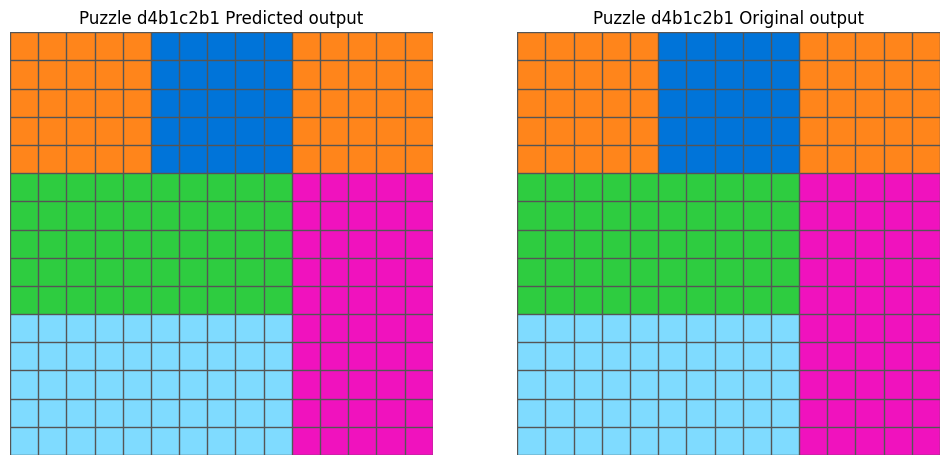

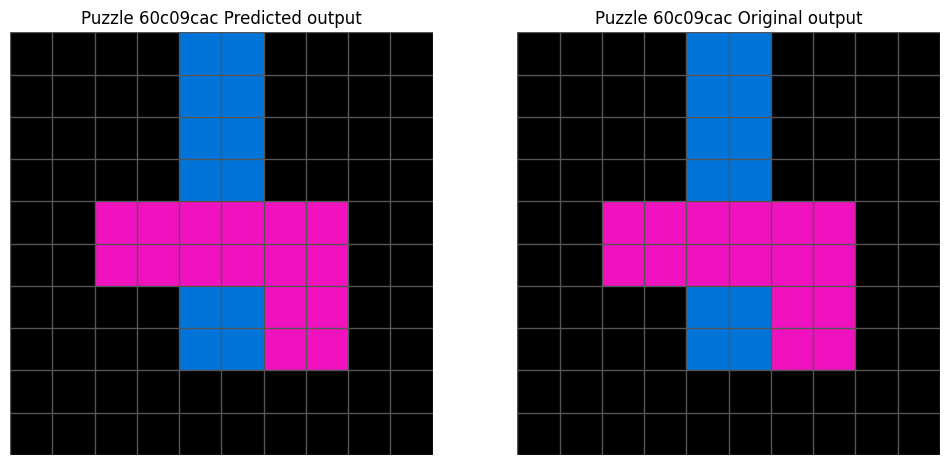

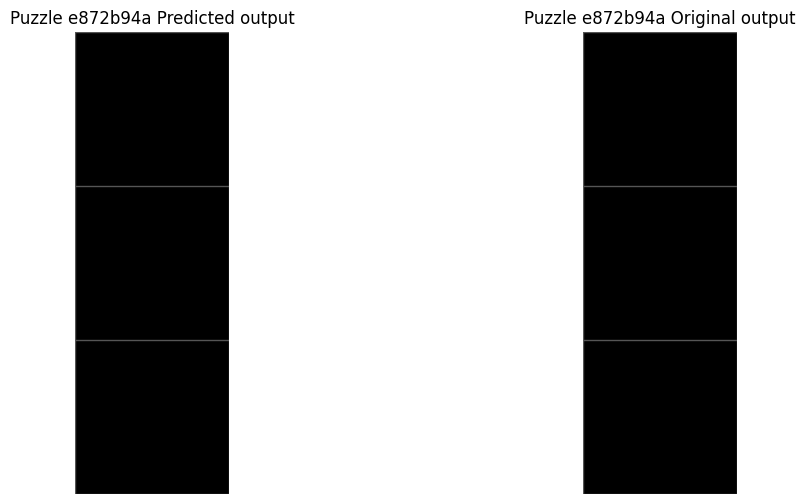

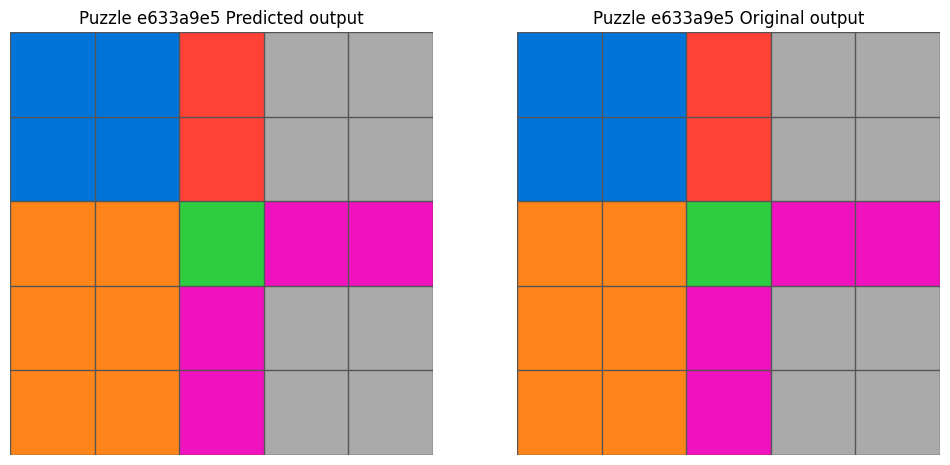

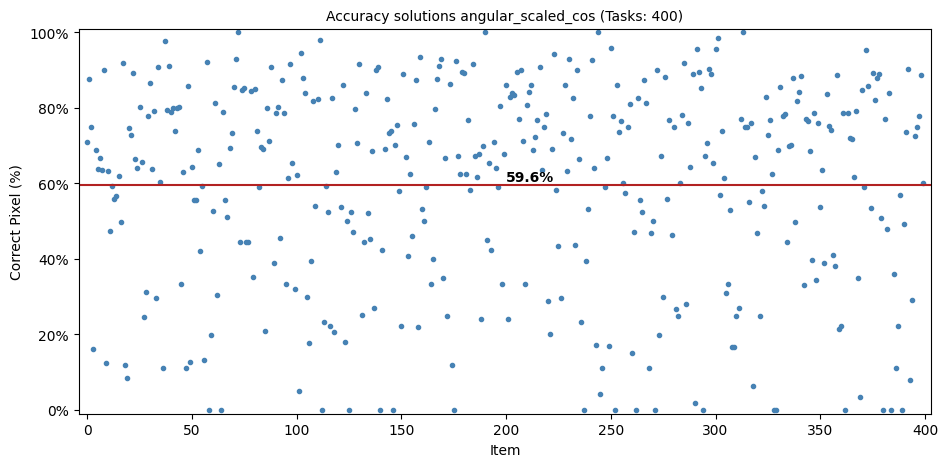

Number of 100% Correct: 4
Number of 90%+ Correct: 37
Number of 80%+ Correct: 106
Number of 70%+ Correct: 178


In [52]:
pred_df = pd.DataFrame(columns=['puzzle_id', 'comp', 'pred', 'accuracy'])
accuracies = []    

# comp = 'angular_avg'
comp = 'angular_scaled_cos'
for puzzle_id, task in data.items():    
    pred, original = visual_analogy_spherical(
        pipeline=pipeline,
        train_pairs=task['train'],
        test_pair=task['test'][0],
        model_type=model_type,
        comp=comp
    )


    acc, perfect = compute_accuracy(pred, original)
    accuracies.append(acc)
    pred_df.loc[len(pred_df)] = [puzzle_id, comp, pred, acc]

    if perfect:
        solved_puzzles.append(puzzle_id)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
        draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

mean = np.mean(accuracies)

ig, ax = plt.subplots(figsize=(11,5))
plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
plt.axhline(mean, xmax = len(accuracies), color='firebrick')
plt.title(f'Accuracy solutions {comp} (Tasks: {len(accuracies)})', size='medium')
plt.xlabel('Item')
plt.ylabel('Correct Pixel (%)')
plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
plt.ylim(-0.01, 1.01)
plt.margins(x=0.01)
plt.show()

print(f'Number of 100% Correct: {accuracies.count(1)}')
print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')
    


In [42]:
from sklearn.decomposition import PCA
def visual_analogy_pca(pipeline: Pipeline, train_pairs, test_pair, model_type="vq"):
    
    pipeline.model_eval()

    with torch.no_grad():
        test_input, test_output = test_pair

        # Encode training pairs
        z_inputs, z_diffs, z_size = process_train_pairs(pipeline, train_pairs, model_type)
        z_test_input, _ = grid_to_latent(pipeline, test_input, model_type)

        # Convert to numpy arrays for PCA
        Z_inputs = np.vstack(z_inputs)
        Z_outputs = Z_inputs + np.vstack(z_diffs)
        Z_combined = np.vstack([Z_inputs, Z_outputs])  # Combine inputs and outputs for richer PCA
        Z_test = z_test_input.reshape(1, -1)

        # Adjust PCA components to avoid invalid dimension error
        n_components = min(64, Z_combined.shape[0], Z_combined.shape[1])

        # Apply PCA to untangle latent space
        pca = PCA(n_components=n_components)
        Z_pca = pca.fit_transform(Z_combined)

        Z_inputs_pca = Z_pca[:len(z_inputs)]
        Z_outputs_pca = Z_pca[len(z_inputs):]
        Z_diffs_pca = Z_outputs_pca - Z_inputs_pca
        Z_test_pca = pca.transform(Z_test)

        # Weighted difference in PCA space using cosine similarity
        cos_sims = cosine_similarity(Z_inputs_pca, Z_test_pca).flatten()
        cos_weights = softmax(cos_sims)
        z_diff_pca = np.sum([w * z for w, z in zip(cos_weights, Z_diffs_pca)], axis=0)

        # Predict in PCA space and inverse transform
        z_pred_pca = Z_test_pca + z_diff_pca
        z_pred = pca.inverse_transform(z_pred_pca)

        # Convert to tensor and reshape
        z_pred_tensor = torch.tensor(z_pred, dtype=torch.float32).to(z_test_input.device)
        z_pred_reshaped = z_pred_tensor.view(*z_size)

        # Decode
        predicted_output = latent_to_grid(pipeline, z_pred_reshaped, test_output, model_type)

    return predicted_output, test_output

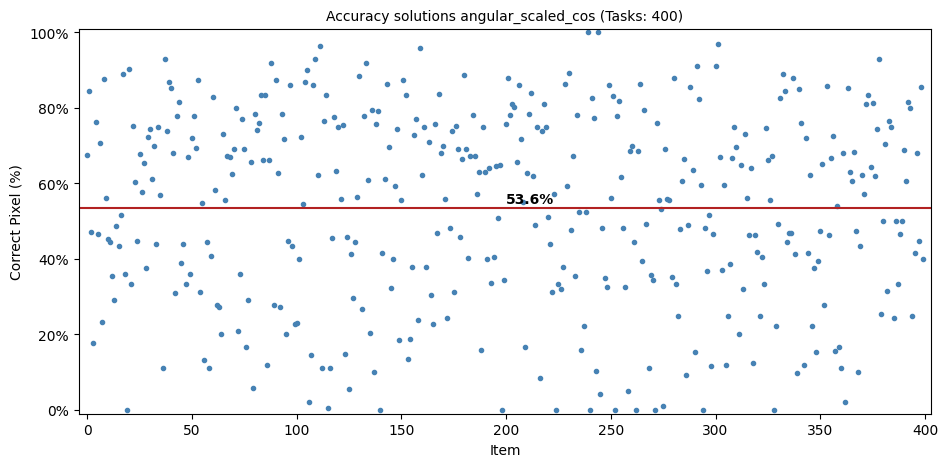

Number of 100% Correct: 2
Number of 90%+ Correct: 14
Number of 80%+ Correct: 65
Number of 70%+ Correct: 125


In [ ]:
pred_df = pd.DataFrame(columns=['puzzle_id', 'comp', 'pred', 'accuracy'])
accuracies = []    

comp = 'angular_avg'
for puzzle_id, task in data.items():    
    pred, original = visual_analogy_pca(
        pipeline=pipeline,
        train_pairs=task['train'],
        test_pair=task['test'][0],
        model_type=model_type,
    )


    acc, perfect = compute_accuracy(pred, original)
    accuracies.append(acc)
    pred_df.loc[len(pred_df)] = [puzzle_id, comp, pred, acc]

    # if perfect:
    #     solved_puzzles.append(puzzle_id)

    #     fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    #     draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
    #     draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

mean = np.mean(accuracies)

ig, ax = plt.subplots(figsize=(11,5))
plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
plt.axhline(mean, xmax = len(accuracies), color='firebrick')
plt.title(f'Accuracy solutions {comp} (Tasks: {len(accuracies)})', size='medium')
plt.xlabel('Item')
plt.ylabel('Correct Pixel (%)')
plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
plt.ylim(-0.01, 1.01)
plt.margins(x=0.01)
plt.show()

print(f'Number of 100% Correct: {accuracies.count(1)}')
print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')
    


In [84]:
def slerp(z_in, z_out, t):
    z_in = z_in / np.linalg.norm(z_in)
    z_out = z_out / np.linalg.norm(z_out)
    
    dot = np.clip(np.dot(z_in, z_out), -1.0, 1.0)
    theta = np.arccos(dot)
    
    if theta < 1e-6:
        # Almost identical vectors: linear interpolation fallback
        return (1 - t) * z_in + t * z_out
    
    sin_theta = np.sin(theta)
    part1 = np.sin((1 - t) * theta) / sin_theta
    part2 = np.sin(t * theta) / sin_theta
    return part1 * z_in + part2 * z_out


def extract_slerp_diff(z_diffs, z_inputs, z_test_input, t=1.0):
    z_inputs = np.array(z_inputs).squeeze(1)
    z_diffs = np.array(z_diffs).squeeze(1)
    z_test_input = np.array(z_test_input).squeeze(0)
    
    z_test_input_norm = z_test_input / np.linalg.norm(z_test_input)
    
    z_outs = z_inputs + z_diffs
    z_outs_norm = z_outs / np.linalg.norm(z_outs, axis=1, keepdims=True)
    
    slerp_points = np.array([
        slerp(z_test_input_norm, z_out_norm, t) for z_out_norm in z_outs_norm
    ])
    
    # Average the SLERP points on the sphere
    avg_slerp = slerp_points.mean(axis=0)
    avg_slerp /= np.linalg.norm(avg_slerp)
    
    # Compute difference from test input
    diff = avg_slerp - z_test_input_norm
    
    # Scale by average magnitude of training deltas
    avg_magnitude = np.mean(np.linalg.norm(z_diffs, axis=1))
    return diff * avg_magnitude

def extract_slerp_target(z_diffs, z_inputs, z_test_input, t=1.0):
    z_inputs = np.array(z_inputs).squeeze(1)
    z_diffs = np.array(z_diffs).squeeze(1)
    z_test_input = np.array(z_test_input).squeeze(0)
    
    # Normalize inputs and compute normalized outputs
    z_test_input_norm = z_test_input / np.linalg.norm(z_test_input)
    z_inputs_norm = z_inputs / np.linalg.norm(z_inputs, axis=1, keepdims=True)
    
    # Calculate target points on the sphere for each training pair
    # z_outs = z_inputs + z_diffs (this is a linear sum, likely off sphere)
    # Instead, let's consider the actual target from the training pair after normalization
    z_train_outputs_norm = (z_inputs + z_diffs) / np.linalg.norm(z_inputs + z_diffs, axis=1, keepdims=True)

    # Now, for each training pair (z_in_norm, z_train_out_norm), we want to find
    # a target for z_test_input_norm such that the transformation is analogous.
    # A common heuristic for A:B::C:D in normalized spaces is D = normalize(C + B - A).
    # Let's apply this for each training pair's analogy and then average.
    
    analogous_targets = []
    for i in range(z_inputs_norm.shape[0]):
        # A:B::C:D  => z_inputs_norm[i] : z_train_outputs_norm[i] :: z_test_input_norm : D
        # D_i = normalize(C + B - A)
        target_i = z_test_input_norm + z_train_outputs_norm[i] - z_inputs_norm[i]
        analogous_targets.append(target_i / np.linalg.norm(target_i)) # Re-normalize each target

    # Average these analogous targets on the sphere
    avg_target = np.mean(analogous_targets, axis=0)
    # avg_target = avg_target / np.linalg.norm(avg_target) # Final normalization

    # The 't' parameter in your original slerp function is not directly used here
    # if you're aiming for the final analogous point, not an interpolation step.
    # If 't' is meant to control the "strength" of the transformation, you'd apply it differently.
    
    # This `avg_target` is now your predicted latent vector.
    return avg_target


def visual_analogy_spherical_slerp(pipeline: Pipeline, train_pairs, test_pair, model_type="vq", direct=True, t=1.0):
    pipeline.model_eval()
    with torch.no_grad():
        test_input, test_output = test_pair
        
        # Encode training pairs into latent space differences
        z_inputs, z_diffs, z_size = process_train_pairs(pipeline, train_pairs, model_type)
        
        # Encode test input latent
        z_test_input, _ = grid_to_latent(pipeline, test_input, model_type)
        
        # Convert test latent to numpy for processing
        z_test_input_np = z_test_input.cpu().numpy() if torch.is_tensor(z_test_input) else z_test_input
        
        
        if direct:
            z_pred_np = extract_slerp_target(z_diffs, z_inputs, z_test_input_np, t=t)
        else:
            # # Compute SLERP-based latent difference vector
            z_diff = extract_slerp_diff(z_diffs, z_inputs, z_test_input_np, t=t)
            
            # Apply the difference to test latent
            z_pred_np = z_test_input_np + z_diff
            # z_pred_np = z_pred_np / np.linalg.norm(z_pred_np)

        # Convert back to tensor and reshape
        z_pred_tensor = torch.from_numpy(z_pred_np).float()
        z_pred_reshaped = z_pred_tensor.view(*z_size)
        
        # Decode to output grid space
        predicted_output = latent_to_grid(pipeline, z_pred_reshaped, test_output, model_type)
        
    return predicted_output, test_output

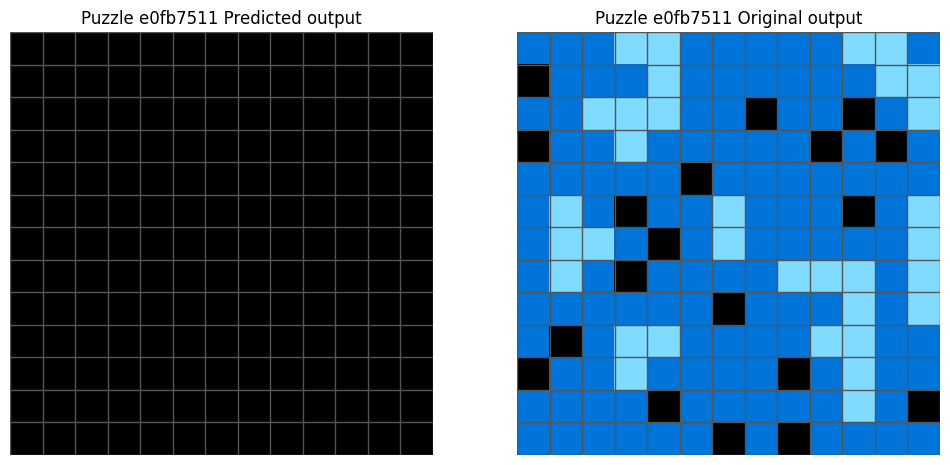

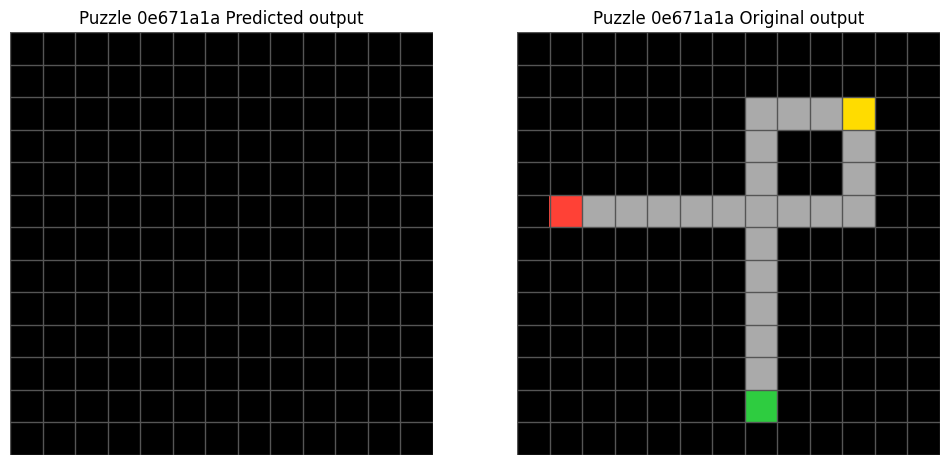

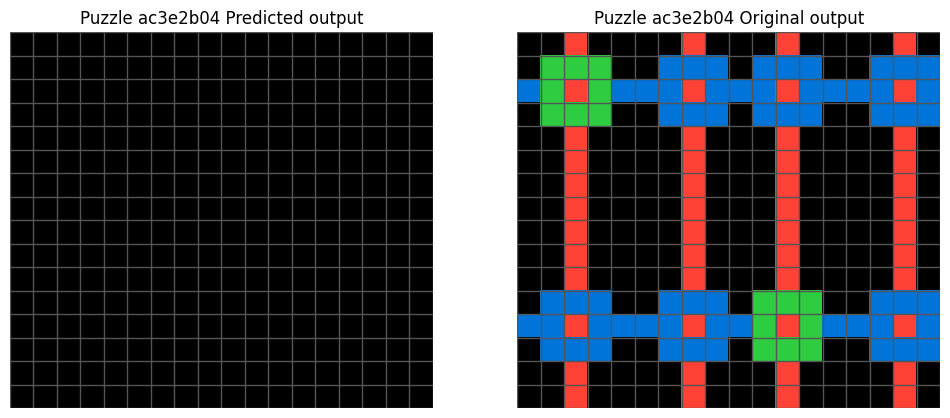

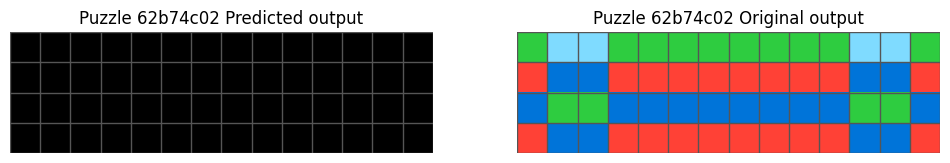

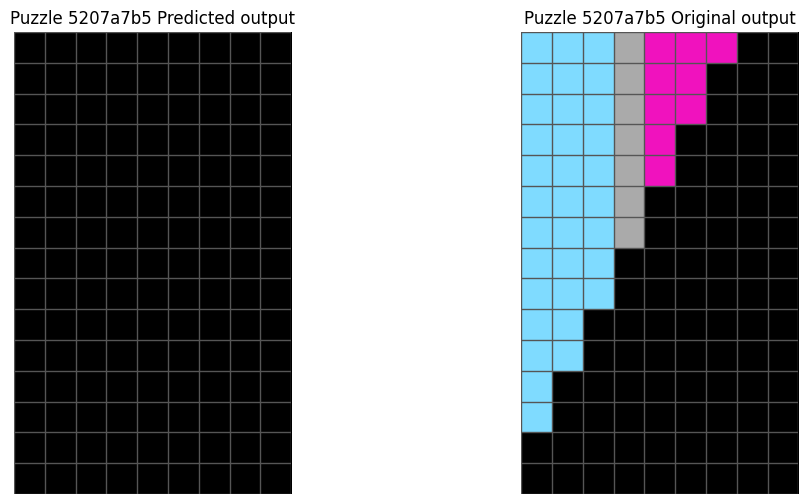

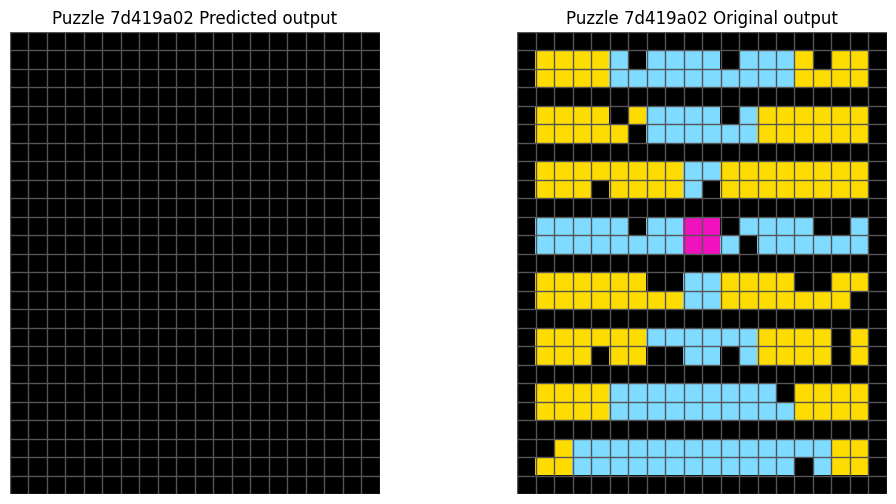

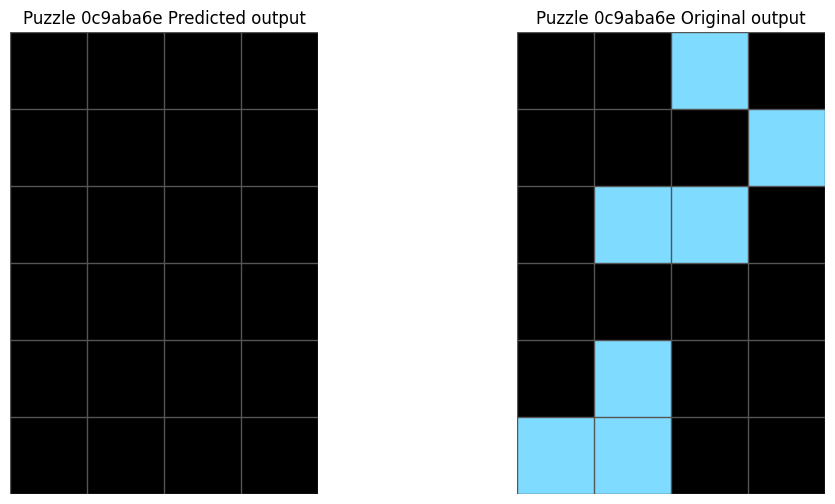

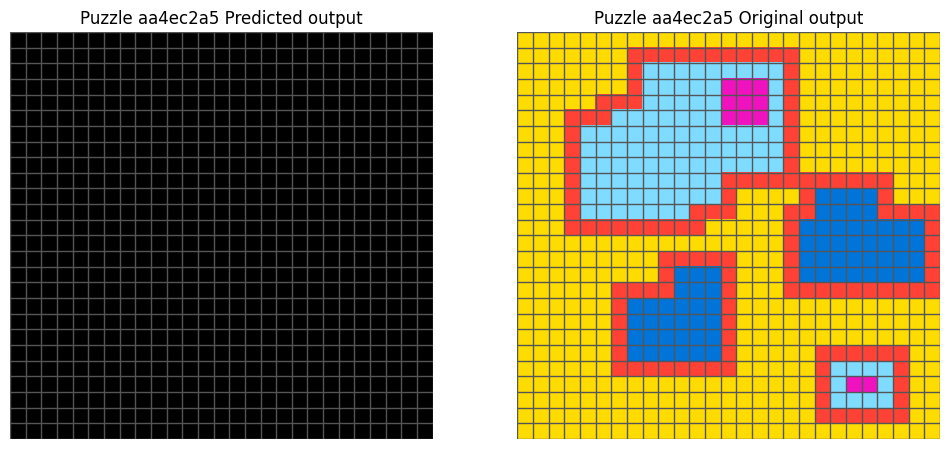

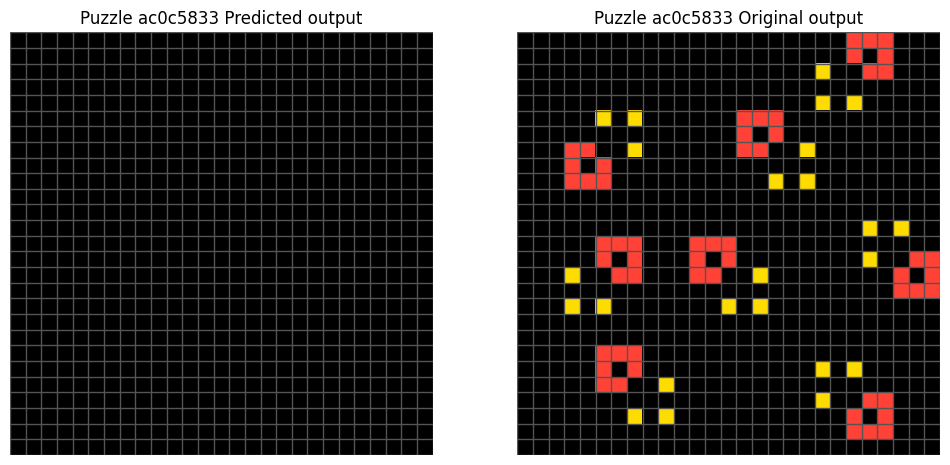

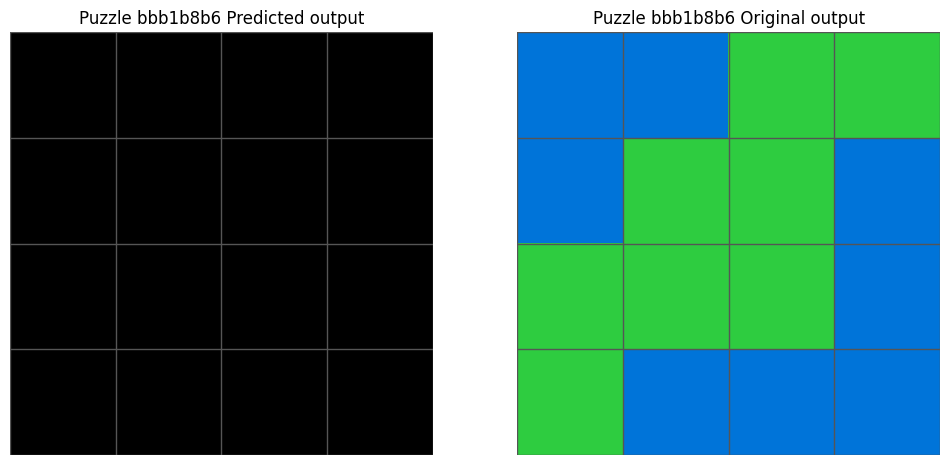

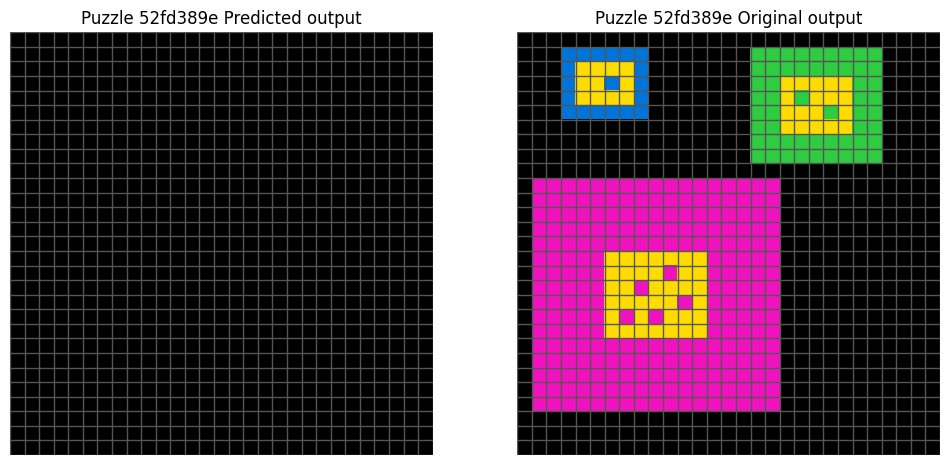

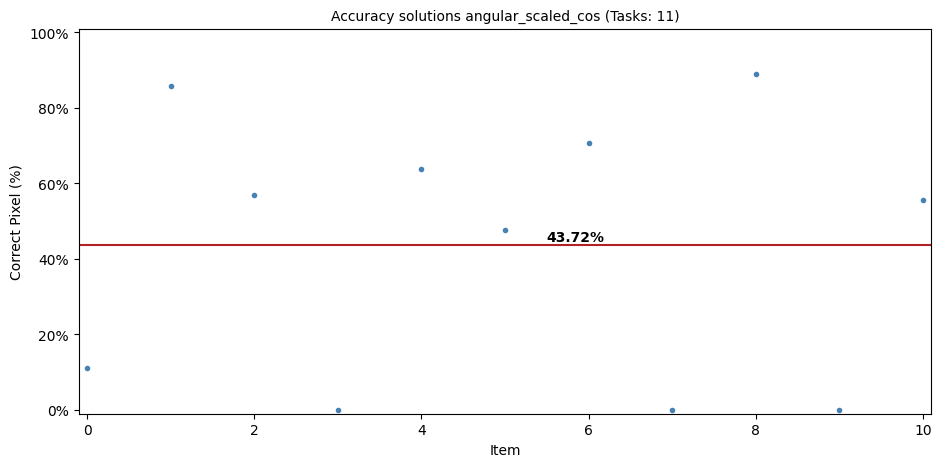

Number of 100% Correct: 0
Number of 90%+ Correct: 0
Number of 80%+ Correct: 2
Number of 70%+ Correct: 3


In [86]:
pred_df = pd.DataFrame(columns=['puzzle_id', 'comp', 'pred', 'accuracy'])
accuracies = []    

counter = 0
for puzzle_id, task in data.items():    
    if counter > 10:
        break
    counter += 1
    pred, original = visual_analogy_spherical_slerp(
        pipeline=pipeline,
        train_pairs=task['train'],
        test_pair=task['test'][0],
        model_type=model_type,
        direct=True,
        t=1.0
    )

    acc, perfect = compute_accuracy(pred, original)
    accuracies.append(acc)
    pred_df.loc[len(pred_df)] = [puzzle_id, comp, pred, acc]

    # if perfect:
    #     solved_puzzles.append(puzzle_id)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
    draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

mean = np.mean(accuracies)

ig, ax = plt.subplots(figsize=(11,5))
plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
plt.axhline(mean, xmax = len(accuracies), color='firebrick')
plt.title(f'Accuracy solutions {comp} (Tasks: {len(accuracies)})', size='medium')
plt.xlabel('Item')
plt.ylabel('Correct Pixel (%)')
plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
plt.ylim(-0.01, 1.01)
plt.margins(x=0.01)
plt.show()

print(f'Number of 100% Correct: {accuracies.count(1)}')
print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')

In [9]:
# import pandas as pd
# def reconstruct_grid(grid, expected_grid, model_type):
#     grid = pipeline.preprocess_and_compress(grid)
#     # print(grid.shape)
#     grid = grid.unsqueeze(0)
#     grid_decoded = grid

#     if model_type == 'vq':
#         z_e = pipeline.encode(grid)
#         z_q, _, _ = pipeline.model.quantize(z_e)
#         grid_decoded = pipeline.decode(z_q)
#     else:
#         z, _ = pipeline.encode(grid)
#         grid_decoded = pipeline.decode(z)

#     grid_decoded = pipeline.decompress_and_postprocess(grid_decoded.squeeze(0), expected_grid)
#     return grid_decoded

# def apply_reconstruction_error(pred, input, input_recon):
#     if pred.shape != input.shape:
#         return pred
    
#     error = input - input_recon
    
#     corrected_pred = pred + error
    
#     return corrected_pred

# # model_type = 'vq'
# pred_df = pd.DataFrame(columns=['puzzle_id', 'comp', 'pred', 'accuracy'])

# for comp in comps:
#     print(comp)
#     accuracies = []    

#     for puzzle_id, task in data.items():
#         test_pair = task['test'][0]
#         pred, original = visual_analogy_single_task(
#             pipeline=pipeline,
#             train_pairs=task['train'],
#             test_pair=test_pair,
#             model_type=model_type,
#             comp=comp
#         )

#         input, _ = test_pair
#         input_recon = reconstruct_grid(input, input, model_type)

#         pred = apply_reconstruction_error(pred, input, input_recon)

#         acc, perfect = compute_accuracy(pred, original)
#         accuracies.append(acc)
        
#         pred_df.loc[len(pred_df)] = [puzzle_id, comp, pred, acc]

#         if perfect:
#             solved_puzzles.append(puzzle_id)

#             fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#             draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
#             draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

#     mean = np.mean(accuracies)

#     ig, ax = plt.subplots(figsize=(11,5))
#     plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
#     plt.axhline(mean, xmax = len(accuracies), color='firebrick')
#     plt.title(f'Accuracy solutions {comp} (Tasks: {len(accuracies)})', size='medium')
#     plt.xlabel('Item')
#     plt.ylabel('Correct Pixel (%)')
#     plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
#     plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
#     plt.ylim(-0.01, 1.01)
#     plt.margins(x=0.01)
#     plt.show()

#     print(f'Number of 100% Correct: {accuracies.count(1)}')
#     print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
#     print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
#     print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')


